<h1><center>Car Features and MSRP</h1>

One of the most significant purchases in many people's lives is a car. Not only is it one of the most expensive purchases (after a house), it is one that is often used daily. Whether buying a car new or used, a savvy consumer will do some research to determine the best fit, from both a feature and value standpoint. Conversely, it is important for car manufacturers to understand what consumers value to determine a fair Manufacturer Suggested Retail Price (MSRP). This study will investigate the relationship between a car's features and its MSRP.

### Data Loading

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import scipy
import numpy as np
import math
import datetime

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from regressors import stats,plots

from collections import Counter

The original data set used was scraped from www.thecarconnection.com and collected by nicolas-gervais in the r/datasets subreddit on Reddit available here: https://www.reddit.com/r/datasets/comments/b6rcwv/i_scraped_32000_cars_including_the_price_and_115/. This set includes all vehicle makes and models available without adjustment for number of vehicles sold so is not necessarily representative of the vehicles actually found on the road but rather this theoretical set.

In [4]:
df = pd.read_csv('../../data/carspecs.csv',low_memory=False)
df = df.T
df.columns = df.iloc[0]
df = df[1:]

In [5]:
df.head(1)

Unnamed: 0,MSRP,Gas Mileage,Engine,EPA Class,Style Name,Drivetrain,Passenger Capacity,Passenger Doors,Body Style,Transmission,EPA Classification,Base Curb Weight (lbs),Front Hip Room (in),Front Leg Room (in),Second Shoulder Room (in),Passenger Volume (ft³),Second Head Room (in),Front Shoulder Room (in),Second Hip Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),Min Ground Clearance (in),"Track Width, Front (in)","Width, Max w/o mirrors (in)","Track Width, Rear (in)","Height, Overall (in)",Cargo Volume to Seat 1 (ft³),Cargo Volume to Seat 2 (ft³),Cargo Volume to Seat 3 (ft³),"Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),Engine Order Code,SAE Net Torque @ RPM,Fuel System,Engine Type,SAE Net Horsepower @ RPM,Displacement,...,"Steering Ratio (:1), On Center","Steering Ratio (:1), At Lock",Spare Tire Capacity (lbs),Front Tire Capacity (lbs),Revolutions/Mile @ 45 mph - Spare,Revolutions/Mile @ 45 mph - Front,Rear Tire Capacity (lbs),Revolutions/Mile @ 45 mph - Rear,Axle Capacity - Front (lbs),Spring Capacity - Front (lbs),Axle Capacity - Rear (lbs),Spring Capacity - Rear (lbs),Maximum Alternator Watts,Fifth Wheel Hitch - Max Trailer Wt. (lbs),Fifth Wheel Hitch - Max Tongue Wt. (lbs),"Length, Overall w/o rear bumper (in)",Front Bumper to Back of Cab (in),"Frame Width, Rear (in)",Cab to Axle (in),"Overhang, Rear w/o bumper (in)",Ground to Top of Frame (in),Cab to End of Frame (in),"Cargo Box Width @ Top, Rear (in)",Cargo Volume (ft³),Cargo Box Width @ Floor (in),Ext'd Cab Cargo Volume (ft³),Cargo Box Length @ Floor (in),Tailgate Width (in),Drivetrain Note,Emissions Note,Fourth Hip Room (in),Fourth Leg Room (in),Fourth Shoulder Room (in),Fourth Head Room (in),Fifth Shoulder Room (in),Fifth Head Room (in),Fifth Hip Room (in),Fifth Leg Room (in),Corrosion Note,Hybrid/Electric Components Note
2019 Acura RDX Specs: FWD w/Technology Pkg,"$40,600",22 mpg City/28 mpg Hwy,"Turbo Premium Unleaded I-4, 2.0 L",Small Sport Utility Vehicles 2WD,FWD w/Technology Pkg,Front Wheel Drive,5,4,Sport Utility,Transmission: 10-Speed Automatic -inc: sequent...,Small Sport Utility Vehicles 2WD,3790,55,41.6,56.6,104,38.3,59.7,49.9,39.6,38.4,108.3,5.7,64.2,74.8,64.7,65.7,58.9,29.5,29.5,17.1,24,22,28,NaN,280 @ 1600,Gasoline Direct Injection,Turbo Premium Unleaded I-4,272 @ 6500,2.0 L/122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.columns.values

array(['MSRP', 'Gas Mileage', 'Engine', 'EPA Class', 'Style Name',
       'Drivetrain', 'Passenger Capacity', 'Passenger Doors',
       'Body Style', 'Transmission', 'EPA Classification',
       'Base Curb Weight (lbs)', 'Front Hip Room (in)',
       'Front Leg Room (in)', 'Second Shoulder Room (in)',
       'Passenger Volume (ft³)', 'Second Head Room (in)',
       'Front Shoulder Room (in)', 'Second Hip Room (in)',
       'Front Head Room (in)', 'Second Leg Room (in)', 'Wheelbase (in)',
       'Min Ground Clearance (in)', 'Track Width, Front (in)',
       'Width, Max w/o mirrors (in)', 'Track Width, Rear (in)',
       'Height, Overall (in)', 'Cargo Volume to Seat 1 (ft³)',
       'Cargo Volume to Seat 2 (ft³)', 'Cargo Volume to Seat 3 (ft³)',
       'Fuel Tank Capacity, Approx (gal)',
       'Fuel Economy Est-Combined (MPG)',
       'EPA Fuel Economy Est - City (MPG)',
       'EPA Fuel Economy Est - Hwy (MPG)', 'Engine Order Code',
       'SAE Net Torque @ RPM', 'Fuel System', 'Engine

Of the 234 features originally included in the data set, 35 of the most available and relevant were initially chosen for investigation.

In [7]:
data = df[['MSRP','Drivetrain','Trans Description Cont.','Body Style',\
           'Passenger Capacity','Passenger Doors','Base Curb Weight (lbs)','Passenger Volume (ft³)',\
           'Front Hip Room (in)','Second Hip Room (in)','Second Leg Room (in)','Front Leg Room (in)',\
           'Front Head Room (in)','Second Head Room (in)','Wheelbase (in)','Height, Overall (in)',\
           'Fuel Tank Capacity, Approx (gal)','EPA Fuel Economy Est - City (MPG)','EPA Fuel Economy Est - Hwy (MPG)',\
           'SAE Net Horsepower @ RPM','Turning Diameter - Curb to Curb (ft)',\
           'Basic Years','Corrosion Years','Drivetrain Years',\
           'Brakes-ABS','Air Bag-Frontal-Driver','Air Bag-Frontal-Passenger',\
           'Air Bag-Side Body-Front','Air Bag-Side Body-Rear','Air Bag-Side Head-Front','Air Bag-Side Head-Rear',\
           'Traction Control','Fog Lamps','Parking Aid','Back-Up Camera']].copy()
data = data.drop_duplicates()

Of the originally selected features, two were missing from at least 10,000 rows so were eliminated, leaving 33 features.

In [8]:
data.isna().sum()

Unnamed: 0
MSRP                                       40
Drivetrain                               1578
Trans Description Cont.                  1863
Body Style                               1578
Passenger Capacity                          0
Passenger Doors                             0
Base Curb Weight (lbs)                  11564
Passenger Volume (ft³)                  12857
Front Hip Room (in)                      4119
Second Hip Room (in)                     6826
Second Leg Room (in)                     5146
Front Leg Room (in)                      2273
Front Head Room (in)                     2316
Second Head Room (in)                    5148
Wheelbase (in)                           1803
Height, Overall (in)                     1864
Fuel Tank Capacity, Approx (gal)         1950
EPA Fuel Economy Est - City (MPG)        4713
EPA Fuel Economy Est - Hwy (MPG)         4713
SAE Net Horsepower @ RPM                 1836
Turning Diameter - Curb to Curb (ft)     2269
Basic Years            

In [9]:
data = data.drop(columns=['Base Curb Weight (lbs)','Passenger Volume (ft³)'])

In [10]:
data = data.dropna()
data.shape

(18991, 33)

The 'SAE Net Horsepower @ RPM' feature was converted into separate Horsepower and RPM features.

In [11]:
#SAE Net Horsepower @ RPM
data['Horsepower'] = data['SAE Net Horsepower @ RPM'].str.replace(r'\d+\s@','')
data['RPM'] = data['SAE Net Horsepower @ RPM'].str.replace(r'@\s\d+','')
data = data.drop(columns=['SAE Net Horsepower @ RPM'])

In [12]:
numeric_cols = data.columns.drop(['Drivetrain','Body Style','Trans Description Cont.'])
data['MSRP'] = data['MSRP'].str.replace(r'[$,]','')
data.replace({'Yes':1,'No':0},inplace=True)
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric,errors='coerce')*1

#### Data Cleaning

Some higher end cars have very high MSRP and may skew results so vehicles with MSRP above $75,000 were excluded. This threshold was chosen as the mean MSRP + 2*standard deviation.

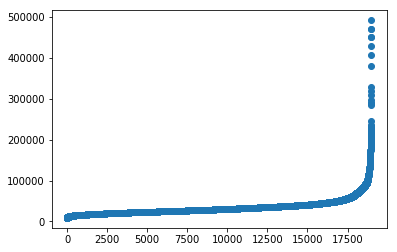

In [13]:
plt.scatter(range(0,len(data)),data['MSRP'].sort_values())

In [14]:
data['MSRP'].mean() + 2*data['MSRP'].std()

77117.39439050507

In [15]:
data = data[data['MSRP'] <= 75000]

#### Categorical variables

Of the remaining features, three were categorical: Drivetrain, Body Style and Trans Description Cont. For modeling purposes, these were converted to dummy variables.

Transmission was simply divided into manual vs. automatic. Some of the names provided are ambiguous so only those that were explicitly named as manual were considered manual.

In [16]:
Counter(data['Trans Description Cont.'])

Counter({'Automatic w/OD': 6953,
         'Automatic w/Manual Shift': 441,
         'Automatic': 3834,
         'Auto-Shift Manual w/OD': 117,
         'Automatic w/OD,': 745,
         'Manual w/OD': 2227,
         'CVT w/OD': 840,
         'Continuously Variable Ratio': 181,
         'Manual': 1614,
         'Automatic w/manual shift': 308,
         'Automatic CVT': 4,
         'CVT Automatic w/OD': 26,
         'Manual w/OD,': 5,
         'Automatic w/Manual Transmission': 4,
         'CVT': 164,
         'Tiptronic': 13,
         'Automatic,': 169,
         'CVT Automatic': 61,
         'S tronic Automatic w/OD': 11,
         'DSG Automatic w/OD': 8,
         'Direct Shift Automatic': 4,
         'HD Automatic w/OD': 39,
         'manual w/OD': 2,
         'automatic w/OD': 3,
         'HD Automatic': 21,
         'HD': 2,
         'Multi-Speed Automatic w/OD': 40,
         'Continuously variable ratio': 32,
         'Auto w/OD': 2,
         'HD Auto w/OD': 2,
         'Electronic':

In [17]:
data['Manual'] = data['Trans Description Cont.'].str.contains('manual',case=False,regex=False) & \
                (data['Trans Description Cont.'].str.contains('auto',case=False,regex=False) == 0)

About 83% of vehicles included were automatic transmission vs. 17% that were manual.

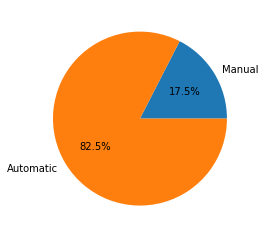

In [18]:
sizes = [ data['Manual'].sum(), len(data['Manual']) ]
labels = ['Manual','Automatic']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

Drivetrains were broken down into: Front Wheel Drive, Rear Wheel Drive, All Wheel Drive and Four Wheel Drive. There were a few vehicles listed as Two Wheel Drive that were excluded since it could not be determined whether they were Front or Rear Wheel Drive.

In [19]:
Counter(data['Drivetrain'])

Counter({'Front Wheel Drive': 6674,
         'All Wheel Drive': 3183,
         '4 Wheel Drive': 255,
         'All-Wheel Drive': 370,
         'Front-Wheel Drive': 185,
         'All wheel drive': 21,
         'All-wheel drive': 6,
         'Rear Wheel Drive': 3968,
         'AWD': 36,
         '2WD': 8,
         '4-Wheel Drive': 1648,
         'RWD': 2,
         'Four Wheel Drive': 1656,
         'REAR WHEEL DRIVE': 15,
         '4WD': 17,
         'Rear wheel drive': 59,
         'Front wheel drive': 43,
         'Four-Wheel Drive': 42,
         'Front-wheel drive': 6,
         'Four wheel drive': 13,
         '2-Wheel Drive': 8,
         '2 Wheel Drive': 22,
         'Rear-Wheel Drive': 7,
         '4-wheel Drive': 1})

In [20]:
data['Front_Wheel_Drive'] = data['Drivetrain'].str.startswith('Front')
data['Rear_Wheel_Drive']  = data['Drivetrain'].str.startswith('R')
data['All_Wheel_Drive']   = data['Drivetrain'].str.startswith('A')
data['Four_Wheel_Drive']  = data['Drivetrain'].str.startswith('Four') | data['Drivetrain'].str.startswith('4')

In [21]:
missing = data.loc[:,['Front_Wheel_Drive','Rear_Wheel_Drive','All_Wheel_Drive','Four_Wheel_Drive']].sum(axis=1)==0
Counter(missing)

Counter({False: 18207, True: 38})

In [22]:
data = data.drop(data[missing].index)

Front wheel drive vehicles accounted for about 38% of vehicles with rear wheel drive, all wheel drive and four wheel drive constituting about between 20-23% each.

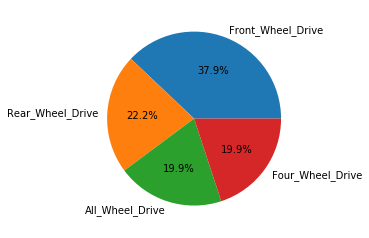

In [23]:
plt.pie(data.iloc[:,-4:].sum().values, labels=data.iloc[:,-4:].columns.values, autopct='%1.1f%%')
plt.show()

Body styles were divided into: SUV, Sedan, Coupe, Station Wagon, Truck and Van. While there were a significant number of Convertibles as well, most of these lacked some of the other data features so these were left out.

In [24]:
Counter(data['Body Style'])

Counter({'Sport Utility': 5849,
         '4dr Car': 5709,
         'Station Wagon': 873,
         'Convertible': 257,
         '2dr Car': 1200,
         'Crew Cab Pickup - Short Bed': 1234,
         'Extended Cab Pickup - Standard Bed': 594,
         'Crew Cab Pickup - Standard Bed': 594,
         'Extended Cab Pickup - Long Bed': 424,
         'Extended Cab Pickup - Short Bed': 790,
         'Full-size Passenger Van': 95,
         'Mini-van, Passenger': 404,
         'Extended Cab Pickup': 2,
         'Crew Cab Pickup - Long Bed': 145,
         '3dr Car': 30,
         'Hatchback': 6,
         'Crew Cab Pickup': 1})

In [25]:
data['SUV'] = data['Body Style'].str.contains('Sport Utility',case=False,regex=False)
data['Sedan'] = data['Body Style'].str.contains('4dr Car',case=False,regex=False)
data['Coupe'] = data['Body Style'].str.contains('2dr Car',case=False,regex=False)
data['Station_Wagon'] = data['Body Style'].str.contains('Station Wagon',case=False,regex=False)
data['Truck'] = data['Body Style'].str.contains('Cab',case=False,regex=False)
data['Van'] = data['Body Style'].str.contains('Pickup',case=False,regex=False)

In [26]:
missing = data.loc[:,['SUV','Sedan','Coupe','Station_Wagon','Truck','Van']].sum(axis=1)==0
Counter(missing)

Counter({False: 17415, True: 792})

In [27]:
data = data.drop(data[missing].index)

The most common body style was SUV at almost 30%, although cars (sedan + coupe + station wagon) totaled about 33%. Both vans and trucks comprised about 19% of vehicles.

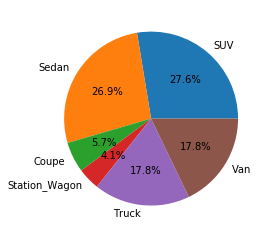

In [28]:
plt.pie(data.iloc[:,-6:].sum().values, labels=data.iloc[:,-6:].columns.values, autopct='%1.1f%%')
plt.show()

In [29]:
data = data.drop(columns=['Drivetrain','Body Style','Trans Description Cont.'])

#### Continuous Variables

From the feature correlation chart, there are definitely some high correlations between continuous variables but these were left in to begin with to be handled by the models.

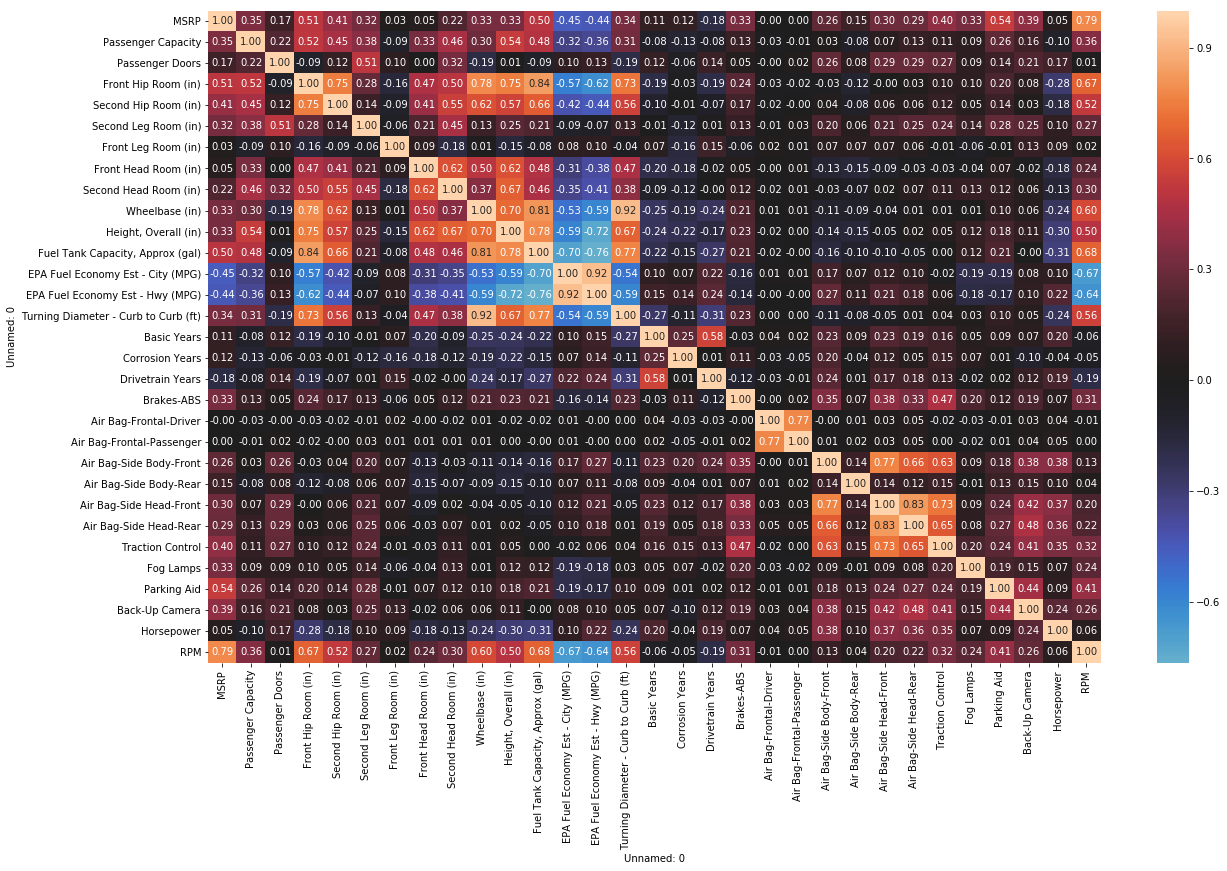

In [30]:
plt.figure(figsize=(20,12))
sns.heatmap(data[numeric_cols].corr(),annot=True,center=0, fmt='0.2f')
plt.show()

After the number of data features has been winnowed, all rows with missing data were dropped, leaving about 14,000 vehicles. This is just under half of the original data set but should still be demonstrative. It is likely that this has increased bias towards specific manufacturers, however, since missing data is probably prevalent across each manufacturer's vehicles.

In [31]:
data.dropna().shape

(14300, 42)

In [32]:
data = data.dropna()

### Research Plan
Due to the number of features remaining and the correlations between some of them, principal component analysis (PCA) was first applied to reduce dimensionality.

A combination of GridSearchCV and model-specific cross validation functions from the scikit-learn toolbox was used for the following models:
- K-Nearest Neighbor
- Decision Tree
- Random Forest
- Ordinary Least Squares Regression
- Ridge Regression
- Lasso Regression
- Support Vector Regression
- Gradient Boosted Regression

Once optimal hyperparameter sets were found, cross validation was performed on the best estimators for each model comparing the training set, test set and full set of data to compare $R^2$ scores across folds.

#### Model Cross Validation Score function
Since model comparisons will be similar, a cross validation score function was written. It performs cross validation using a given model estimator on the training set, the test set and the combined set. A boxplot comparing the $R^{2}$ scores for each fold is also generated.

In [33]:
def model_cv_scores(model_estimator, X_train, Y_train, X_test, Y_test, cv_folds=12, show_graph=True, graph_title=''):
    
    import pandas as pd
    import numpy as np
    from matplotlib import pyplot as plt
    %matplotlib inline
    import seaborn as sns

    # Convert array to DataFrame if necessary so that later functions apply
    if ~isinstance(X_train,pd.DataFrame):
        X_train = pd.DataFrame(data=X_train)
        X_test = pd.DataFrame(data=X_test)
        Y_train = pd.DataFrame(data=Y_train)
        Y_test = pd.DataFrame(data=Y_test)    
    
    X = X_train.append(X_test)
    Y = Y_train.append(Y_test)
    
    # Calculate cross-val scores for training, test and full sets independently
    score_train = cross_val_score(model_estimator, X_train, Y_train, cv=cv_folds, n_jobs=5)
    score_test = cross_val_score(model_estimator, X_test, Y_test, cv=cv_folds, n_jobs=5)
    score_full = cross_val_score(model_estimator, X, Y, cv=cv_folds, n_jobs=5)
    
    # Generate graphs
    if show_graph==True:
        # Generate graphs
        plot_DataFrame = pd.DataFrame(data={'Training': score_train, 'Test': score_test, 'Full': score_full})

        # Create boxplot comparing R^2 scores
        plt.figure
        sns.boxplot(data=plot_DataFrame)
        plt.title('{}\nCross Validation ({} folds): R\u00b2'.format(graph_title,cv_folds))
        plt.ylabel('R\u00b2')
        plt.show()

        # Create KDE plot showing residuals
        plt.figure
        resids = np.subtract(Y['MSRP'].values,model_estimator.predict(X))
        #print(model_estimator.predict(X).shape)
        g = sns.jointplot(model_estimator.predict(X), resids, kind='hex', xlim=[0,75000], ylim=[-30000,30000])
        g.set_axis_labels('Projected','Residual')
        g.fig.suptitle('{}\nResiduals'.format(graph_title), y=1.05)
        plt.show()

    # Output best parameters
    if hasattr(model_estimator,'best_params_'):
        print("Best parameters:   {}".format(model_estimator.best_params_))
        
    # Output R^2 means and 95% confidence intervals
    print("R\u00b2 (training set): {0:0.5f} (+/- {1:0.5f})".format(score_train.mean(), score_train.std() * 2))
    print("R\u00b2 (test set):     {0:0.5f} (+/- {1:0.5f})".format(score_test.mean(), score_test.std() * 2))
    print("R\u00b2 (full set):     {0:0.5f} (+/- {1:0.5f})".format(score_full.mean(), score_full.std() * 2))
    
    return score_train, score_test, score_full

### Data Preparation

MSRP was defined as the outcome variable with all of the remaining variables used as predictors.

In [34]:
tgt = data*1
Y = tgt['MSRP']
X = tgt.loc[:, ~tgt.columns.isin(['MSRP'])]

With over 40 variables, some models will take a long time to run. Preferably, a method such as Principal Component Analysis (PCA) could yield comparable results while significantly improving runtimes.

Some methods such as K-Nearest Neighbors (using distance) require equal-scaled variables.

In [35]:
X0_scaled = preprocessing.scale(X)

The data were split into a 80% training/20% test set.

In [36]:
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0_scaled, Y, test_size=0.2)

Performance of the K-Nearest Neighbors model is highly dependent on number of samples when testing. Since initial testing was just used to determine viability of PCA, best estimator was determined using GridSearchCV but cross-validation was not applied on the subsequent model. R^2 score was quite high but runtime was slow.

In [37]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

knn0 = KNeighborsRegressor()
knn_fit0 = GridSearchCV(knn0,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).fit(X0_train, Y0_train)
print("K-Nearest Neighbors R\u00b2 score {0:0.5f}: ".format(r2_score(Y0_test, knn_fit0.predict(X0_test))))

K-Nearest Neighbors R² score 0.94929: 


### Principal Component Analysis

Looking at the PCA results, about half of variance is explained within the first four components with each of the first ten components explaining at least 2.5% of variance.

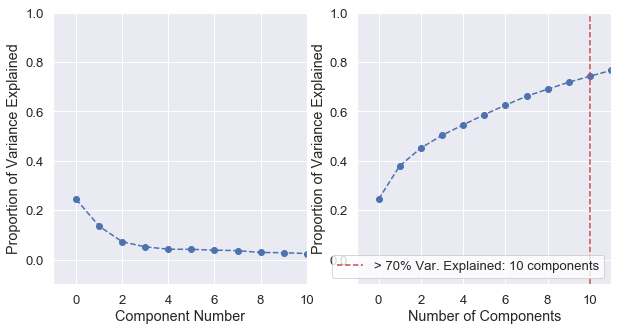

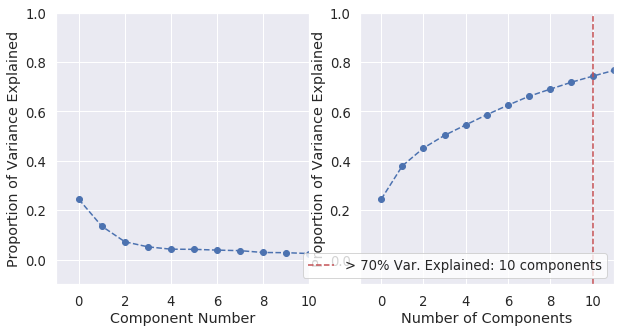

In [38]:
X_scaled = preprocessing.scale(X)
pca = PCA(n_components=20).fit(X_scaled)
plots.plot_scree(pca, required_var=0.7)

In [39]:
pca = PCA(n_components=10).fit(X_scaled)
X_pca_raw = pca.transform(X_scaled)
X_pca = pd.DataFrame(data=X_pca_raw,index=X.index)

The data were split into a 80% training/20% test set.

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.2)

Applying the K-Nearest Neighbors model again using the reduced data set actually yields a higher $R^2$ value, suggesting using PCA with the first ten principal components is a suitable means of reducing dimensionality. Cross-validation was applied later to support these results.

In [41]:
# K Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

knn = KNeighborsRegressor()
knn_fit = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).fit(X_train, Y_train)
print("K-Nearest Neighbors (PCA) R\u00b2 score: {0:0.5f}".format(r2_score(Y_test, knn_fit.predict(X_test))))

K-Nearest Neighbors (PCA) R² score: 0.94432


### K-Nearest Neighbors
GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|n_neighbors|1-5|4
|weights|uniform/distance|distance

Both the training and full sets have relatively high $R^2$ values with a tight range among folds but this falls when comparing against the test set, suggesting possible overfitting. The residuals appear tight and normally distributed around 0.

|Set|Mean|95% CI
|-|-|-
|Training|0.93815|0.01908
|Test|0.87749|0.05163
|Full|0.94744|0.01090

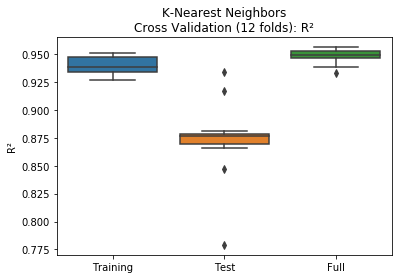

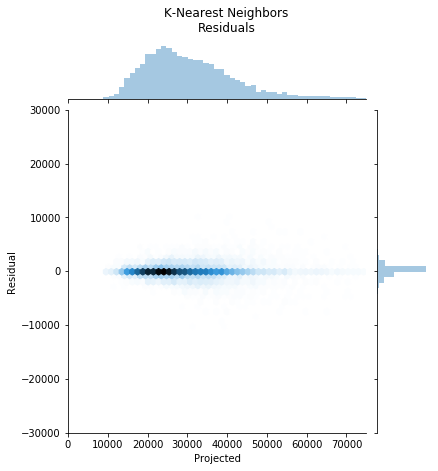

Best parameters:   {'n_neighbors': 4, 'weights': 'distance'}
R² (training set): 0.93927 (+/- 0.01588)
R² (test set):     0.87309 (+/- 0.07138)
R² (full set):     0.94759 (+/- 0.01251)


In [42]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).fit(X_train, Y_train)
knn_train, knn_test, knn_full = model_cv_scores(knn_fit, X_train, Y_train, X_test, Y_test, 12, True, 'K-Nearest Neighbors')

### Decision Tree
GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|max_depth|1-8|7
|max_features|1-10|9

The Decision Tree model performs worse than the K-Nearest Neighbors model. There may be some overfitting as the $R^2$ for the test set is a little lower than the training set with a wider range as well. Residuals are wider than K-Nearest Neighbors but still appear to be normal around 0. There is some 'choppiness' in predicted values but due to the nature of the model this is not surprising since predictions are limited by the original data set.

|Set|Mean|95% CI
|-|-|-
|Training|0.80706|0.02408
|Test|0.74523|0.09312
|Full|0.80708|0.03266

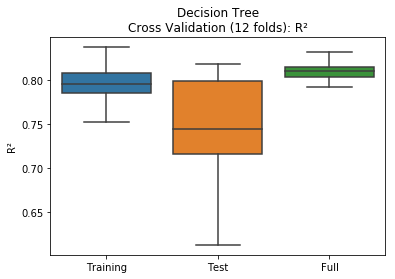

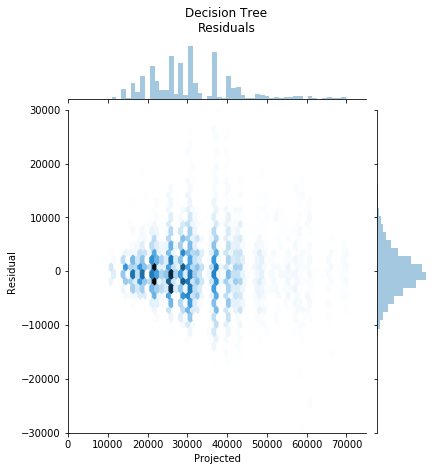

Best parameters:   {'max_depth': 7, 'max_features': 8}
R² (training set): 0.79646 (+/- 0.04110)
R² (test set):     0.74522 (+/- 0.11551)
R² (full set):     0.80923 (+/- 0.02128)


In [43]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
grid_values = {'max_features': range(1,10),'max_depth':range(1,8)}
dt_fit = GridSearchCV(dt, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X_train, Y_train)

dt_train, dt_test, dt_full = model_cv_scores(dt_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Decision Tree')

### Random Forest
To increase accuracy, n_estimators was increased to 100 and then GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|max_depth|2-5|4
|max_features|3-7|6

The Random Forest model performs worse than either of the two previous models. Considering its similarity to the Decision Tree model, this is a bit surprising. However, comparing the optimal hyperparameters chosen by GridSearchCV and looking at the training vs. test results, this may be partly due to overfitting in the Decision Tree model. The Decision Tree model used max_depth = 7 and max_features = 9 compared to only 4 and 6 respectively for the Random Forest model. There does appear to be a slight positive skew in the residual distribution but this is relatively small.

|Set|Mean|95% CI
|-|-|-
|Training|0.71624|0.02931
|Test|0.70291|0.04634
|Full|0.71328|0.02272

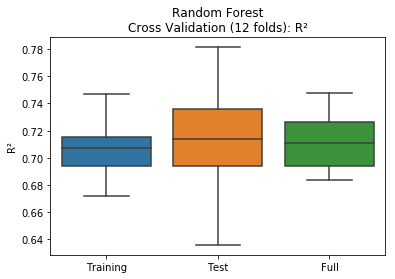

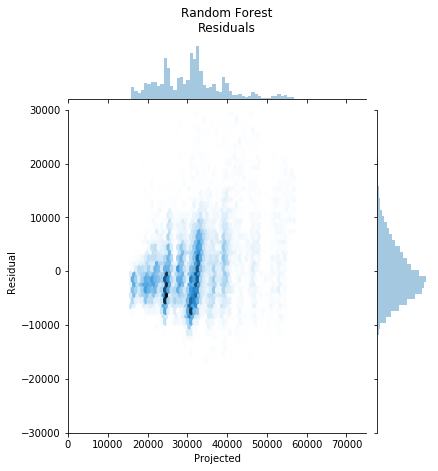

Best parameters:   {'max_depth': 4, 'max_features': 6}
R² (training set): 0.70721 (+/- 0.03810)
R² (test set):     0.71398 (+/- 0.08144)
R² (full set):     0.71220 (+/- 0.03942)


In [44]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)

grid_values = {'max_features': range(3,7),'max_depth':range(2,5)}
rf_fit = GridSearchCV(rf, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X_train, Y_train)

rf_train, rf_test, rf_full = model_cv_scores(rf_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Random Forest')

### Ordinary Least Squares Regression
The OLS model performs slightly better than Random Forest but has a slightly wider range of cross-validation $R^2$ scores. The training and test scores do appear consistent and residuals are normally distributed around 0, though.

|Set|Mean|95% CI
|-|-|-
|Training|0.76212|0.03343
|Test|0.75579|0.06738
|Full|0.76128|0.03149

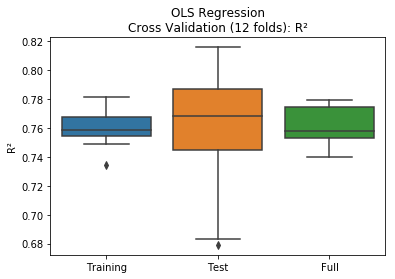

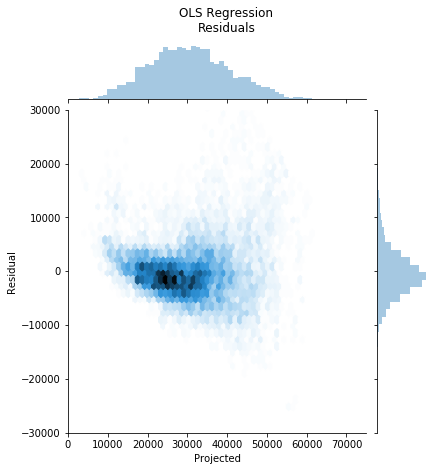

R² (training set): 0.76047 (+/- 0.02495)
R² (test set):     0.76114 (+/- 0.08423)
R² (full set):     0.76130 (+/- 0.02423)


In [45]:
# Ordinary Least Squares Regression
from sklearn.linear_model import LinearRegression
ols_fit = LinearRegression(n_jobs=5).fit(X_train, Y_train)

ols_train, ols_test, ols_full = model_cv_scores(ols_fit, X_train, Y_train, X_test, Y_test, 12, True, 'OLS Regression')

### Ridge Regression
RidgeCV was used to determine optimal alpha:

|Parameter|Range/Options|Optimal
|-|-|-
|alpha|1e-3...1e3|10

The Ridge regression performs similarly to the OLS model.

|Set|Mean|95% CI
|-|-|-
|Training|0.76212|0.03342
|Test|0.75578|0.06710
|Full|0.76128|0.03147

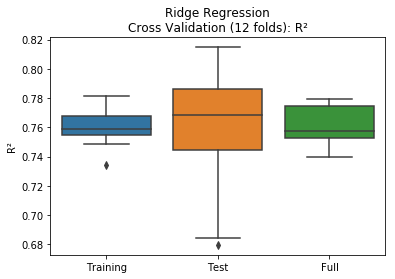

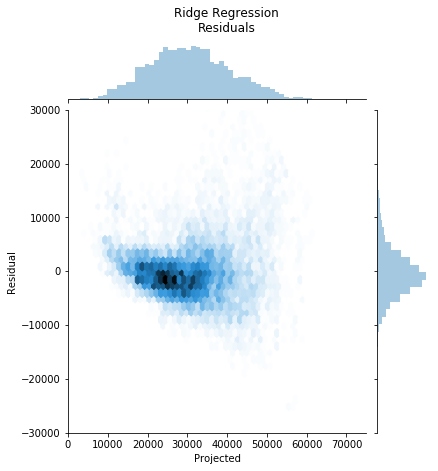

R² (training set): 0.76047 (+/- 0.02494)
R² (test set):     0.76109 (+/- 0.08371)
R² (full set):     0.76129 (+/- 0.02415)
Best alpha: 10.0


In [46]:
# Ridge Regression
from sklearn.linear_model import RidgeCV
ridge_fit = RidgeCV(cv=10,alphas=[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]).fit(X_train, Y_train)

ridge_train, ridge_test, ridge_full = model_cv_scores(ridge_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Ridge Regression')
print('Best alpha: {}'.format(ridge_fit.alpha_))

### Lasso Regression
LassoCV was used to determine optimal alpha:

|Parameter|Range/Options|Optimal
|-|-|-
|alpha|eps=1e-4|1.7125

The Ridge regression performs similarly to the OLS and Ridge regression models.

|Set|Mean|95% CI
|-|-|-
|Training|0.76283|0.01960
|Test|0.75351|0.06928
|Full|0.76145|0.01785

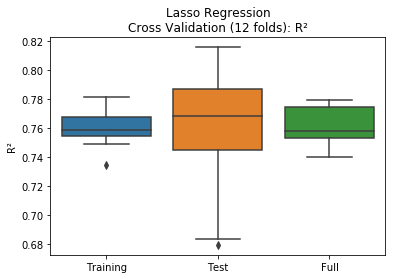

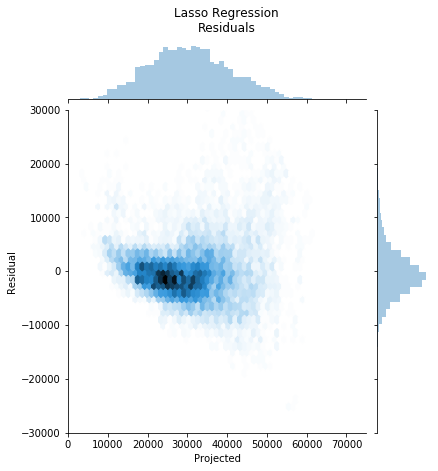

R² (training set): 0.76047 (+/- 0.02494)
R² (test set):     0.76114 (+/- 0.08415)
R² (full set):     0.76130 (+/- 0.02421)
Best alpha: 1.6876014601458011


In [47]:
# Lasso Regression
from sklearn.linear_model import LassoCV
lasso_fit = LassoCV(cv=10,eps=1e-4).fit(X_train, Y_train)

lasso_train, lasso_test, lasso_full = model_cv_scores(lasso_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Lasso Regression')
print('Best alpha: {}'.format(lasso_fit.alpha_))

### Linear Support Vector Regression
GridSearch was used to determine optimal C and epsilon:

|Parameter|Range/Options|Optimal
|-|-|-
|C|100,1000|1000
|epsilon|0.15,0.20,0.25|0.2

The Linear Support Vector regression performed similarly to the OLS/Ridge/Lasso regressions as well.  However, the cross validation scores across the folds were more consistent with the mean $R^2$ slightly higher for the test set and the 95% confidence intervals more similar. Residuals appear normal around 0.

|Set|Mean|95% CI
|-|-|-
|Training|0.74564|0.03443
|Test|0.76246|0.03876
|Full|0.74986|0.03695

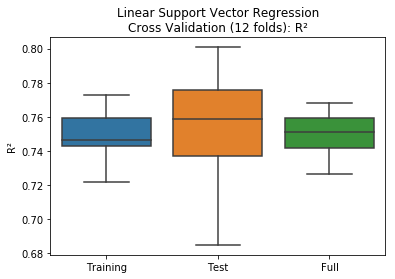

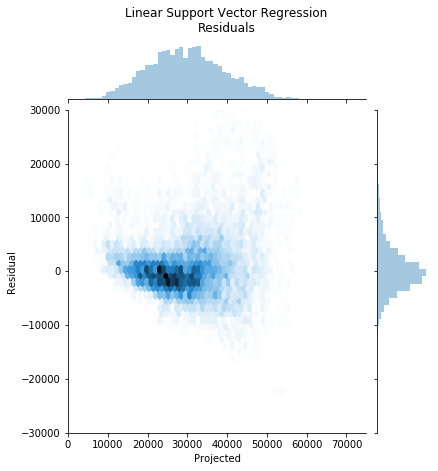

Best parameters:   {'C': 1000, 'epsilon': 0.25, 'kernel': 'linear'}
R² (training set): 0.74862 (+/- 0.02605)
R² (test set):     0.75201 (+/- 0.07176)
R² (full set):     0.74952 (+/- 0.02372)


In [48]:
# Linear Support Vector Regressor
from sklearn.svm import SVR
svr = SVR(gamma='scale')
grid_values = {'C': [100,1000], 'epsilon': [0.15,0.2,0.25], 'kernel': ['linear']}
svr_fit = GridSearchCV(svr, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X_train,Y_train)

svr_train, svr_test, svr_full = model_cv_scores(svr_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Linear Support Vector Regression')

### Radial Basis Kernel Function Support Vector Regression
GridSearch was used to determine optimal C and epsilon:

|Parameter|Range/Options|Optimal
|-|-|-
|C|100,1000|100
|epsilon|0.05,0.50,5.00|0.05

Although $R^2$ scores for the training and full sets are in line with most of the other models, the $R^2$ for the test set is considerably lower with wider 95% confidence interval, suggesting that this model is overfit. Residuals appear normal around 0 and appear more evenly distributed.

|Set|Mean|95% CI
|-|-|-
|Training|0.76381|0.02812
|Test|0.62553|0.07286
|Full|0.78188|0.03522

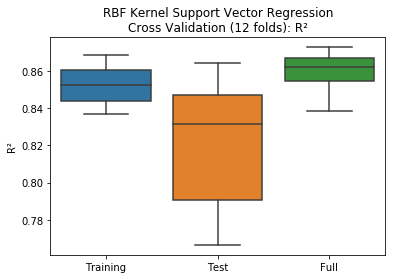

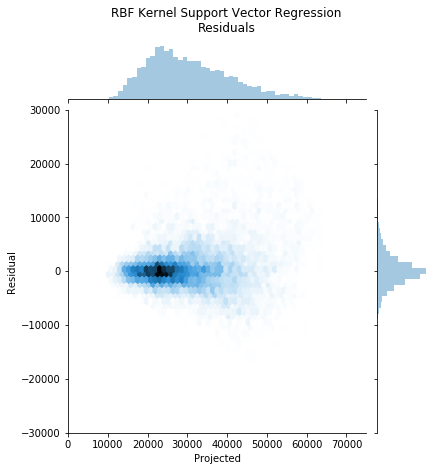

Best parameters:   {'C': 1000, 'epsilon': 5, 'kernel': 'rbf'}
R² (training set): 0.85222 (+/- 0.02147)
R² (test set):     0.82131 (+/- 0.06816)
R² (full set):     0.85917 (+/- 0.02082)


In [49]:
# Radial Basis Function Kernel Support Vector Regressor
from sklearn.svm import SVR
svr = SVR(gamma='scale')
grid_values = {'C': [100,1000], 'epsilon': [0.05,0.5,5], 'kernel': ['rbf']}
rbf_fit = GridSearchCV(svr, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X_train,Y_train)

rbf_train, rbf_test, rbf_full = model_cv_scores(rbf_fit, X_train, Y_train, X_test, Y_test, 12, True, 'RBF Kernel Support Vector Regression')

### Gradient Boosting Regression
To increase accuracy, n_estimators was increased to 500 and then GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|max_depth|2-5|4
|max_features|3-7|5

The Gradient Boosting regression performed well, in line with K-Nearest Neighbors for the best model.

|Set|Mean|95% CI
|-|-|-
|Training|0.92027|0.01575
|Test|0.88684|0.04045
|Full|0.92339|0.01514

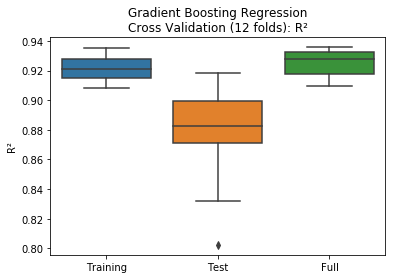

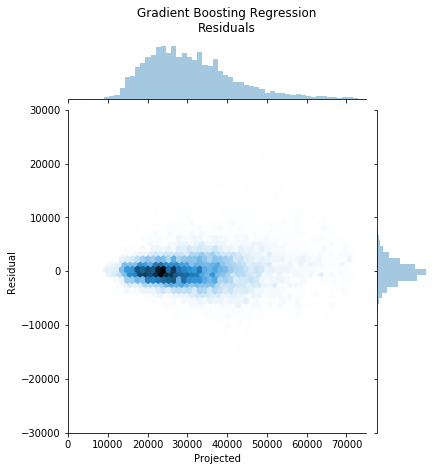

Best parameters:   {'max_depth': 4, 'max_features': 6}
R² (training set): 0.92149 (+/- 0.01581)
R² (test set):     0.87749 (+/- 0.06283)
R² (full set):     0.92530 (+/- 0.01706)


In [50]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=500)
grid_values = {'max_features': range(3,7),'max_depth':range(2,5)}
gb_fit = GridSearchCV(gb, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X_train, Y_train)

gb_train, gb_test, gb_full = model_cv_scores(gb_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Gradient Boosting Regression')

### Model Comparison

First, combine all test data.

In [144]:
test_data = np.column_stack((knn_test.T, np.asarray(['KNN']*12)))
test_data = np.vstack((test_data,np.column_stack((dt_test.T, np.asarray(['Decision_Tree']*12)))))
test_data = np.vstack((test_data,np.column_stack((rf_test.T, np.asarray(['Random_Forest']*12)))))
test_data = np.vstack((test_data,np.column_stack((ols_test.T, np.asarray(['OLS']*12)))))
test_data = np.vstack((test_data,np.column_stack((ridge_test.T, np.asarray(['Ridge']*12)))))
test_data = np.vstack((test_data,np.column_stack((lasso_test.T, np.asarray(['Lasso']*12)))))
test_data = np.vstack((test_data,np.column_stack((svr_test.T, np.asarray(['Linear_SVR']*12)))))
test_data = np.vstack((test_data,np.column_stack((rbf_test.T, np.asarray(['RBF_SVR']*12)))))
test_data = np.vstack((test_data,np.column_stack((gb_test.T, np.asarray(['Gradient_Boosting']*12)))))
test_df = pd.DataFrame(data=test_data,columns=['R^2','Model'])
test_df['R^2'] = test_df['R^2'].astype(float)
test_df['Full_Set'] = True

The K-Nearest Neighbors model and the Gradient Boosting regression performed best while Random Forest performed worst. The majority of models had R2 scores around 0.75 with 95% confidence intervals about 0.05 wide.

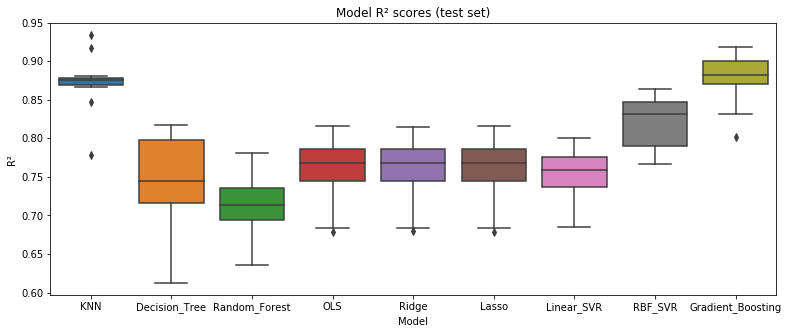

In [158]:
plt.figure(figsize=(13,5))
sns.boxplot(data=test_df,y='R^2',x='Model')
plt.title('Model R\u00b2 scores (test set)')
plt.ylabel('R\u00b2')
plt.show()

## Sedans Only

Of the categorical variables included, body style may be the most relevant to consumers as different body styles have different functionalities. For example, a sedan is more likely to be used as a family car while a truck may be used for hauling. Since sedan is the most common body style, models were run again on a sedan-only data set to determine whether body style affected optimal model.

### Data Preparation

The sedan subset was selected.

In [51]:
tgt2 = data.query('Sedan == True')

MSRP was defined as the outcome variable with all of the remaining variables used as predictors.

In [52]:
Y2 = tgt2['MSRP']
X2 = tgt2.loc[:, ~tgt2.columns.isin(['MSRP','SUV','Sedan','Coupe','Station_Wagon','Truck','Van'])]

### Principal Component Analysis

Looking at the PCA results, about half of variance is explained within the first four components with each of the first ten components explaining at least 3.0% of variance.

In [53]:
X2_scaled = preprocessing.scale(X2)
pca2 = PCA(n_components=10).fit(X2_scaled)
pca2.explained_variance_ratio_

array([0.22300937, 0.13262062, 0.08030093, 0.07574272, 0.05853642,
       0.04604865, 0.04165267, 0.03639873, 0.03372653, 0.03183919])

In [54]:
X2_pca_raw = pca2.transform(X2_scaled)
X2_pca = pd.DataFrame(data=X2_pca_raw,index=X2.index)

The data were split into a 80% training/20% test set.

In [55]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2_pca, Y2, test_size=0.2)

### K-Nearest Neighbors
GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|n_neighbors|1-5|3
|weights|uniform/distance|distance

The sedan-only model had slightly higher $R^2$ scores for the training and full set but the test set was lower and the 95% confidence interval almost doubled.

|Set|Sedan-Only Mean|95% CI|Full Set Mean|95% CI
|-|-|-|-|-
|Training|0.94307|0.02970|0.93815|0.01908
|Test|0.85263|0.09243|0.87749|0.05163
|Full|0.95127|0.02034|0.94744|0.01090

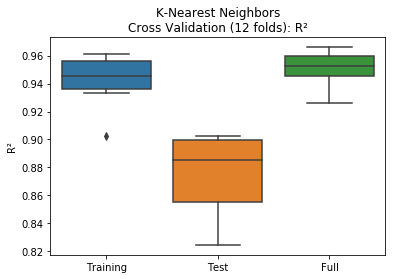

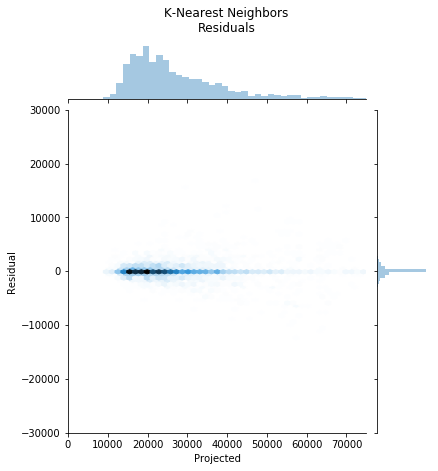

Best parameters:   {'n_neighbors': 2, 'weights': 'distance'}
R² (training set): 0.94325 (+/- 0.03121)
R² (test set):     0.87679 (+/- 0.05035)
R² (full set):     0.95193 (+/- 0.02246)


In [56]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).fit(X2_train, Y2_train)
knn2_train, knn2_test, knn2_full = model_cv_scores(knn_fit, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'K-Nearest Neighbors')

### Decision Tree
GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|max_depth|1-8|7
|max_features|1-10|9

The sedan-only model had higher $R^2$ scores across all sets but similar to K-Nearest Neighbors, the 95% confidence interval significantly widened.

|Set|Sedan-Only Mean|95% CI|Full Set Mean|95% CI
|-|-|-|-|-
|Training|0.87555|0.04745|0.80706|0.02408
|Test|0.78094|0.17447||0.74523|0.09312
|Full|0.87819|0.04113||0.80708|0.03266

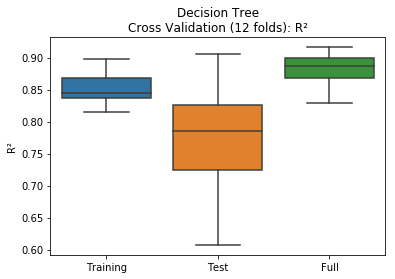

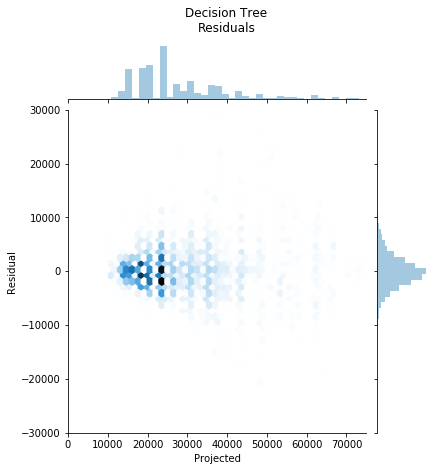

Best parameters:   {'max_depth': 7, 'max_features': 8}
R² (training set): 0.85031 (+/- 0.04960)
R² (test set):     0.77408 (+/- 0.15568)
R² (full set):     0.88000 (+/- 0.05320)


In [57]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
grid_values = {'max_features': range(1,10),'max_depth':range(1,8)}
dt_fit = GridSearchCV(dt, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X2_train, Y2_train)

dt2_train, dt2_test, dt2_full = model_cv_scores(dt_fit, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'Decision Tree')

### Random Forest
To increase accuracy, n_estimators was increased to 100 and then GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|max_depth|2-5|4
|max_features|3-7|6

The sedan-only model had higher $R^2$ scores across all sets with a significantly wider 95% confidence interval.

|Set|Sedan-Only Mean|95% CI|Full Set Mean|95% CI
|-|-|-|-|-
|Training|0.81536|0.05484|0.71624|0.02931
|Test|0.79130|0.07296|0.70291|0.04634
|Full|0.81803|0.04607|0.71328|0.02272

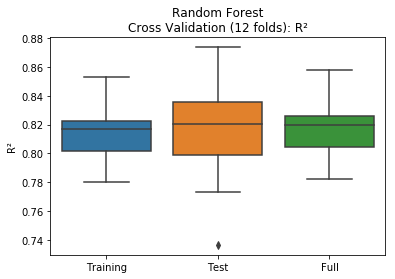

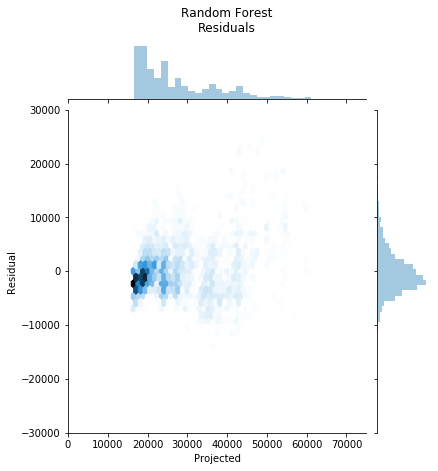

Best parameters:   {'max_depth': 4, 'max_features': 6}
R² (training set): 0.81384 (+/- 0.03851)
R² (test set):     0.81423 (+/- 0.07034)
R² (full set):     0.81793 (+/- 0.03783)


In [58]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)

grid_values = {'max_features': range(3,7),'max_depth':range(2,5)}
rf_fit = GridSearchCV(rf, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X2_train, Y2_train)

rf2_train, rf2_test, rf2_full = model_cv_scores(rf_fit, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'Random Forest')

### Ordinary Least Squares Regression
The sedan-only model had $R^2$ scores similar to the full set with a significantly wider 95% confidence interval.

|Set|Sedan-Only Mean|95% CI|Full Set Mean|95% CI
|-|-|-|-|-
|Training|0.77511|0.04090|0.76212|0.03343
|Test|0.75426|0.05996|0.75579|0.06738
|Full|0.77244|0.04249|0.76128|0.03149

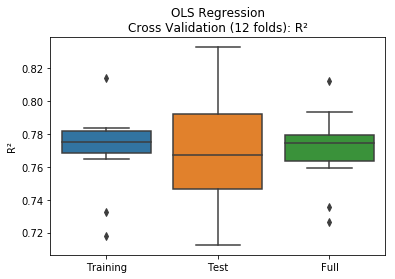

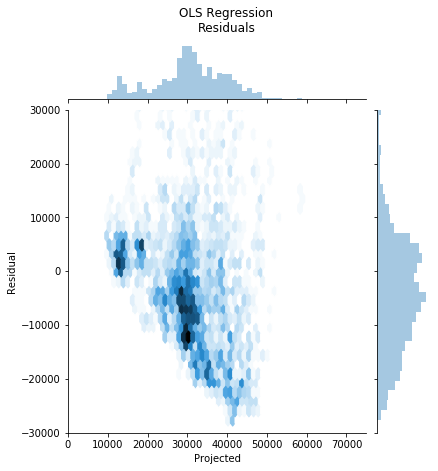

R² (training set): 0.77063 (+/- 0.04710)
R² (test set):     0.76786 (+/- 0.07127)
R² (full set):     0.77096 (+/- 0.04421)


In [59]:
# Ordinary Least Squares Regression
from sklearn.linear_model import LinearRegression
ols_fit = LinearRegression(n_jobs=5).fit(X_train, Y_train)

ols2_train, ols2_test, ols2_full = model_cv_scores(ols_fit, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'OLS Regression')

### Ridge Regression
RidgeCV was used to determine optimal alpha:

|Parameter|Range/Options|Optimal
|-|-|-
|alpha|1e-3...1e3|100

The sedan-only model had $R^2$ scores similar to the full set with a significantly wider 95% confidence interval. However, the optimal alpha chosen was 100 compared to 10 for the full data set.

|Set|Sedan-Only Mean|95% CI|Full Set Mean|95% CI
|-|-|-|-|-
|Training|0.77524|0.04078|0.76212|0.03342
|Test|0.75418|0.05796|0.75578|0.06710
|Full|0.77242|0.04238|0.76128|0.03147

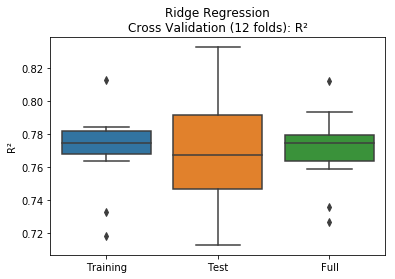

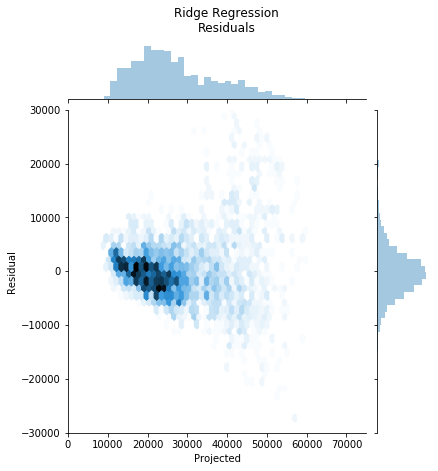

R² (training set): 0.77047 (+/- 0.04671)
R² (test set):     0.76792 (+/- 0.07120)
R² (full set):     0.77086 (+/- 0.04411)
Best alpha: 10.0


In [60]:
# Ridge Regression
from sklearn.linear_model import RidgeCV
ridge_fit = RidgeCV(cv=10,alphas=[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]).fit(X2_train, Y2_train)

ridge2_train, ridge2_test, ridge2_full = model_cv_scores(ridge_fit, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'Ridge Regression')
print('Best alpha: {}'.format(ridge_fit.alpha_))

### Lasso Regression
LassoCV was used to determine optimal alpha:

|Parameter|Range/Options|Optimal
|-|-|-
|alpha|eps=1e-4|2.4929

The sedan-only model had $R^2$ scores similar to the full set with a significantly wider 95% confidence interval for the training and full sets but a slightly tighter one for the test set. The optimal alpha chosen increased from 1.7125 to 2.4929.

|Set|Sedan-Only Mean|95% CI|Full Set Mean|95% CI
|-|-|-|-|-
|Training|0.77511|0.04090|0.76283|0.01960
|Test|0.75375|0.06072|0.75351|0.06928
|Full|0.77244|0.04249|0.76145|0.01785

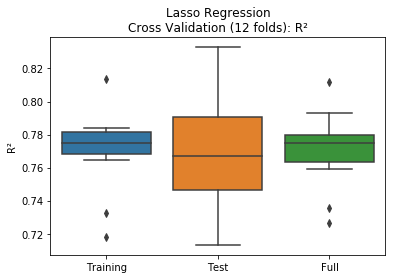

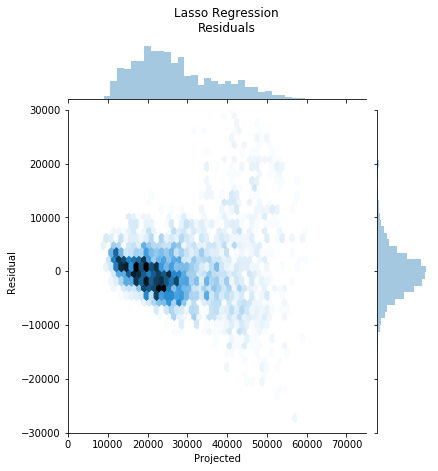

R² (training set): 0.77063 (+/- 0.04706)
R² (test set):     0.76788 (+/- 0.07055)
R² (full set):     0.77096 (+/- 0.04416)
Best alpha: 2.478590758616213


In [61]:
# Lasso Regression
from sklearn.linear_model import LassoCV
lasso_fit = LassoCV(cv=10,eps=1e-4).fit(X2_train, Y2_train)

lasso2_train, lasso2_test, lasso2_full = model_cv_scores(lasso_fit, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'Lasso Regression')
print('Best alpha: {}'.format(lasso_fit.alpha_))

### Linear Support Vector Regression
GridSearch was used to determine optimal C and epsilon:

|Parameter|Range/Options|Optimal
|-|-|-
|C|100,1000|1000
|epsilon|0.15,0.20,0.25|0.15

The sedan-only model had $R^2$ scores similar to the full set with a significantly wider 95% confidence interval. The optimal epsilon chosen decreased from 0.20 to 0.15 while C remained at 1000.

|Set|Sedan-Only Mean|95% CI|Full Set Mean|95% CI
|-|-|-|-|-
|Training|0.75854|0.04530|0.74564|0.03443
|Test|0.73797|0.06568|0.76246|0.03876
|Full|0.75585|0.04011|0.74986|0.03695

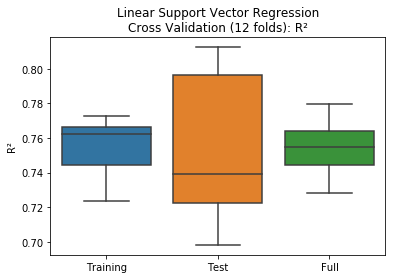

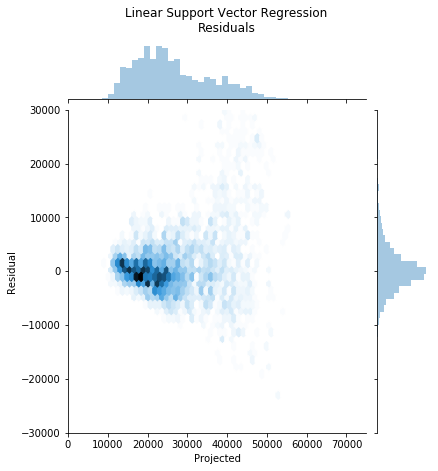

Best parameters:   {'C': 1000, 'epsilon': 0.15, 'kernel': 'linear'}
R² (training set): 0.75482 (+/- 0.03044)
R² (test set):     0.75102 (+/- 0.08440)
R² (full set):     0.75467 (+/- 0.02755)


In [62]:
# Linear Support Vector Regressor
from sklearn.svm import SVR
svr = SVR(gamma='scale')
grid_values = {'C': [100,1000], 'epsilon': [0.15,0.2,0.25], 'kernel': ['linear']}
svr_fit = GridSearchCV(svr, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X2_train,Y2_train)

svr2_train, svr2_test, svr2_full = model_cv_scores(svr_fit, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'Linear Support Vector Regression')

### Radial Basis Kernel Function Support Vector Regression
GridSearch was used to determine optimal C and epsilon:

|Parameter|Range/Options|Optimal
|-|-|-
|C|100,1000|1000
|epsilon|0.05,0.50,5.00|5.00

The sedan-only model had $R^2$ scores higher than the full set with a significantly wider 95% confidence interval. Like the full set, the $R^2$ score for the test set was considerably lower than the training set. The optimal C increased from 100 to 1000 and epsilon from 0.05 to 5.

|Set|Sedan-Only Mean|95% CI|Full Set Mean|95% CI
|-|-|-|-|-
|Training|0.82849|0.07488|0.76381|0.02812
|Test|0.71365|0.10847|0.62553|0.07286
|Full|0.83887|0.04384|0.78188|0.03522

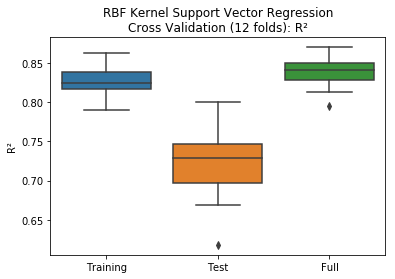

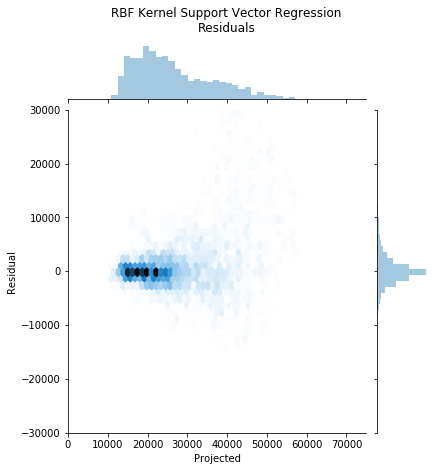

Best parameters:   {'C': 1000, 'epsilon': 5, 'kernel': 'rbf'}
R² (training set): 0.82690 (+/- 0.03670)
R² (test set):     0.72339 (+/- 0.09643)
R² (full set):     0.83774 (+/- 0.03847)


In [63]:
# Radial Basis Function Kernel Support Vector Regressor
from sklearn.svm import SVR
svr = SVR(gamma='scale')
grid_values = {'C': [100,1000], 'epsilon': [0.05,0.5,5], 'kernel': ['rbf']}
rbf_fit = GridSearchCV(svr, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X2_train,Y2_train)

rbf2_train, rbf2_test, rbf2_full = model_cv_scores(rbf_fit, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'RBF Kernel Support Vector Regression')

### Gradient Boosting Regression
To increase accuracy, n_estimators was increased to 500 and then GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|max_depth|2-5|4
|max_features|3-7|5

The sedan-only model had $R^2$ scores in line with the full set with a significantly wider 95% confidence interval. It performs in line with the K-Nearest Neighbors model and has a higher test set $R^2$ score.

|Set|Sedan-Only Mean|95% CI|Full Set Mean|95% CI
|-|-|-|-|-
|Training|0.94313|0.01749|0.92027|0.01575
|Test|0.88169|0.08568|0.88684|0.04045
|Full|0.94761|0.02293|0.92339|0.01514

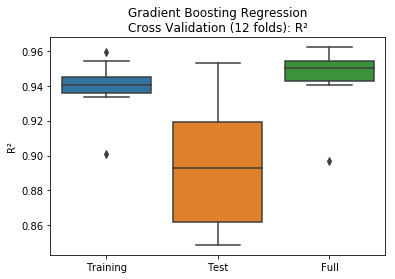

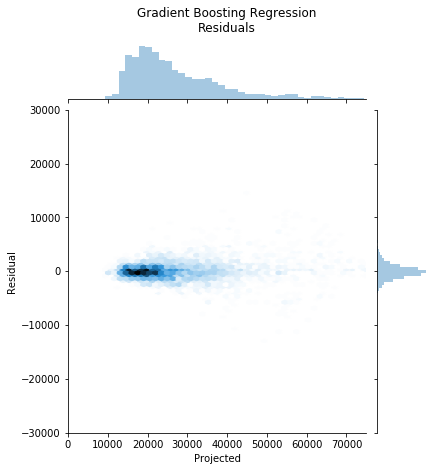

Best parameters:   {'max_depth': 4, 'max_features': 5}
R² (training set): 0.93959 (+/- 0.02766)
R² (test set):     0.89381 (+/- 0.06825)
R² (full set):     0.94606 (+/- 0.03268)


In [64]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=500)
grid_values = {'max_features': range(3,7),'max_depth':range(2,5)}
gb_fit = GridSearchCV(gb, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X2_train, Y2_train)

gb2_train, gb2_test, gb2_full = model_cv_scores(gb_fit, X2_train, Y2_train, X2_test, Y2_test, 12, True, 'Gradient Boosting Regression')

### Model Comparison

First, combine all test data.

In [149]:
test2_data = np.column_stack((knn2_test.T, np.asarray(['KNN']*12)))
test2_data = np.vstack((test2_data,np.column_stack((dt2_test.T, np.asarray(['Decision_Tree']*12)))))
test2_data = np.vstack((test2_data,np.column_stack((rf2_test.T, np.asarray(['Random_Forest']*12)))))
test2_data = np.vstack((test2_data,np.column_stack((ols2_test.T, np.asarray(['OLS']*12)))))
test2_data = np.vstack((test2_data,np.column_stack((ridge2_test.T, np.asarray(['Ridge']*12)))))
test2_data = np.vstack((test2_data,np.column_stack((lasso2_test.T, np.asarray(['Lasso']*12)))))
test2_data = np.vstack((test2_data,np.column_stack((svr2_test.T, np.asarray(['Linear_SVR']*12)))))
test2_data = np.vstack((test2_data,np.column_stack((rbf2_test.T, np.asarray(['RBF_SVR']*12)))))
test2_data = np.vstack((test2_data,np.column_stack((gb2_test.T, np.asarray(['Gradient_Boosting']*12)))))
test2_df = pd.DataFrame(data=test2_data,columns=['R^2','Model'])
test2_df['R^2'] = test2_df['R^2'].astype(float)

The $R^2$ scores for the models using the sedan-only data set perform similarly to the full data set with a couple of exceptions. K-Nearest Neighbors and Gradient Boosting were the strongest for both data sets but Random Forest went from the worst model in the full data set to the third best in the sedan-only data set. Conversely, Radial Basis Function Kernel SVR went from the third best model in the full data set to the worst in the sedan-only data set and went from considerably outperforming Linear SVR to performing slightly worse.

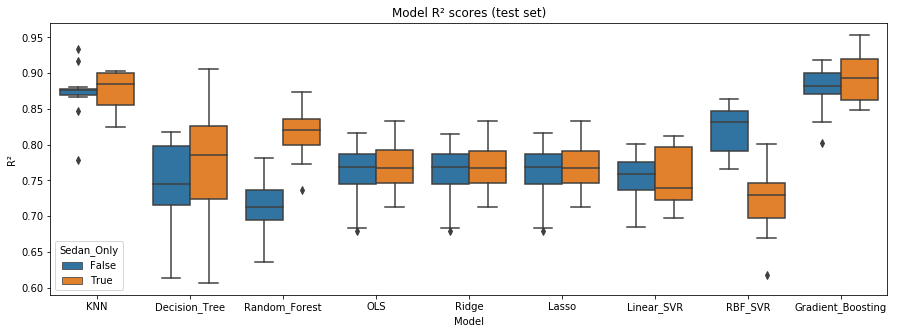

In [152]:
test_df['Sedan_Only'] = False
test2_df['Sedan_Only'] = True
combined_df = test_df.append(test2_df)

plt.figure(figsize=(15,5))
sns.boxplot(data=combined_df,y='R^2',x='Model',hue='Sedan_Only')
plt.title('Model R\u00b2 scores (test set)')
plt.ylabel('R\u00b2')
plt.show()

## K-Nearest Neighbors by Body Style

The K-Nearest Neighbors model performed well in both the full and sedan-only sets. To determine whether body style affected performance of K-Nearest Neighbors, the model was applied on each individual body style.

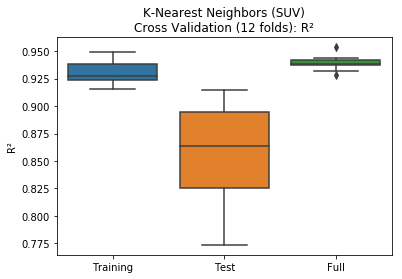

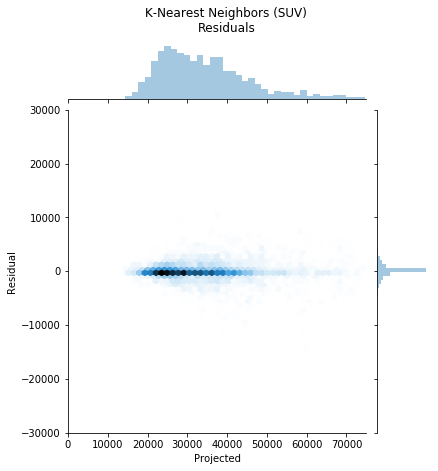

Best parameters:   {'n_neighbors': 4, 'weights': 'distance'}
R² (training set): 0.92982 (+/- 0.02024)
R² (test set):     0.85629 (+/- 0.09158)
R² (full set):     0.93916 (+/- 0.01190)


In [65]:
# SUV
tgt_SUV = data.query('SUV == True')
Y_SUV = tgt_SUV['MSRP']
X_SUV = tgt_SUV.loc[:, ~tgt_SUV.columns.isin(['MSRP'])]

X_SUV_scaled = preprocessing.scale(X_SUV)
pca_SUV = PCA(n_components=10).fit(X_SUV_scaled)
X_SUV_pca_raw = pca_SUV.transform(X_SUV_scaled)
X_SUV_pca = pd.DataFrame(data=X_SUV_pca_raw,index=X_SUV.index)
X_SUV_train, X_SUV_test, Y_SUV_train, Y_SUV_test = train_test_split(X_SUV_pca, Y_SUV, test_size=0.2)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit_SUV = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).\
    fit(X_SUV_train, Y_SUV_train)
knn_SUV_train, knn_SUV_test, knn_SUV_full = model_cv_scores(knn_fit_SUV, X_SUV_train, Y_SUV_train, \
                                                   X_SUV_test, Y_SUV_test, 12, True, 'K-Nearest Neighbors (SUV)')

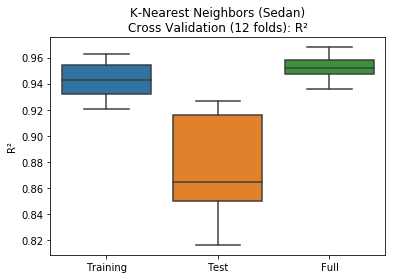

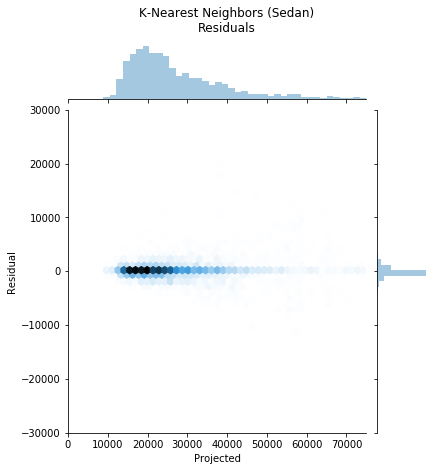

Best parameters:   {'n_neighbors': 4, 'weights': 'distance'}
R² (training set): 0.94312 (+/- 0.02534)
R² (test set):     0.87390 (+/- 0.07573)
R² (full set):     0.95274 (+/- 0.01749)


In [66]:
# Sedan
tgt_Sedan = data.query('Sedan == True')
Y_Sedan = tgt_Sedan['MSRP']
X_Sedan = tgt_Sedan.loc[:, ~tgt_Sedan.columns.isin(['MSRP'])]

X_Sedan_scaled = preprocessing.scale(X_Sedan)
pca_Sedan = PCA(n_components=10).fit(X_Sedan_scaled)
X_Sedan_pca_raw = pca_Sedan.transform(X_Sedan_scaled)
X_Sedan_pca = pd.DataFrame(data=X_Sedan_pca_raw,index=X_Sedan.index)
X_Sedan_train, X_Sedan_test, Y_Sedan_train, Y_Sedan_test = train_test_split(X_Sedan_pca, Y_Sedan, test_size=0.2)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit_Sedan = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).\
    fit(X_Sedan_train, Y_Sedan_train)
knn_Sedan_train, knn_Sedan_test, knn_Sedan_full = model_cv_scores(knn_fit_Sedan, X_Sedan_train, Y_Sedan_train, \
                                                   X_Sedan_test, Y_Sedan_test, 12, True, 'K-Nearest Neighbors (Sedan)')

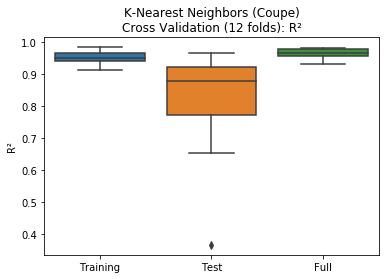

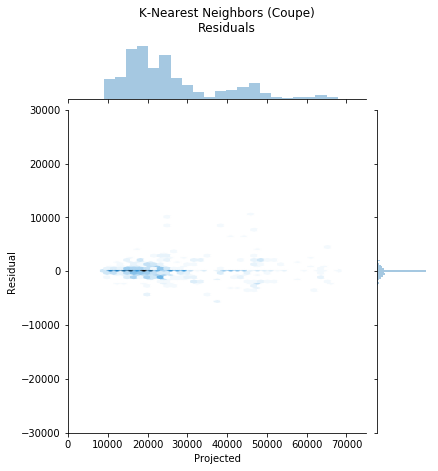

Best parameters:   {'n_neighbors': 4, 'weights': 'distance'}
R² (training set): 0.95346 (+/- 0.03732)
R² (test set):     0.81731 (+/- 0.32486)
R² (full set):     0.96509 (+/- 0.03001)


In [67]:
# Coupe
tgt_Coupe = data.query('Coupe == True')
Y_Coupe = tgt_Coupe['MSRP']
X_Coupe = tgt_Coupe.loc[:, ~tgt_Coupe.columns.isin(['MSRP'])]

X_Coupe_scaled = preprocessing.scale(X_Coupe)
pca_Coupe = PCA(n_components=10).fit(X_Coupe_scaled)
X_Coupe_pca_raw = pca_Coupe.transform(X_Coupe_scaled)
X_Coupe_pca = pd.DataFrame(data=X_Coupe_pca_raw,index=X_Coupe.index)
X_Coupe_train, X_Coupe_test, Y_Coupe_train, Y_Coupe_test = train_test_split(X_Coupe_pca, Y_Coupe, test_size=0.2)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit_Coupe = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).\
    fit(X_Coupe_train, Y_Coupe_train)
knn_Coupe_train, knn_Coupe_test, knn_Coupe_full = model_cv_scores(knn_fit_Coupe, X_Coupe_train, Y_Coupe_train, \
                                                   X_Coupe_test, Y_Coupe_test, 12, True, 'K-Nearest Neighbors (Coupe)')

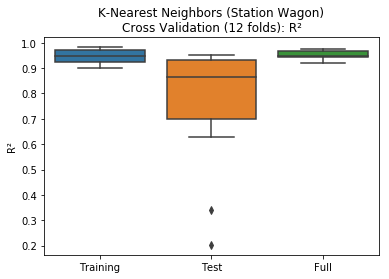

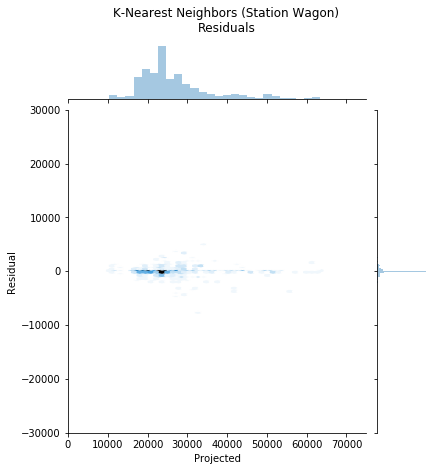

Best parameters:   {'n_neighbors': 4, 'weights': 'distance'}
R² (training set): 0.94681 (+/- 0.05451)
R² (test set):     0.75807 (+/- 0.47766)
R² (full set):     0.95201 (+/- 0.03510)


In [68]:
# Station Wagon
tgt_SW = data.query('Station_Wagon == True')
Y_SW = tgt_SW['MSRP']
X_SW = tgt_SW.loc[:, ~tgt_SW.columns.isin(['MSRP'])]

X_SW_scaled = preprocessing.scale(X_SW)
pca_SW = PCA(n_components=10).fit(X_SW_scaled)
X_SW_pca_raw = pca_SW.transform(X_SW_scaled)
X_SW_pca = pd.DataFrame(data=X_SW_pca_raw,index=X_SW.index)
X_SW_train, X_SW_test, Y_SW_train, Y_SW_test = train_test_split(X_SW_pca, Y_SW, test_size=0.2)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit_SW = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).\
    fit(X_SW_train, Y_SW_train)
knn_SW_train, knn_SW_test, knn_SW_full = model_cv_scores(knn_fit_SW, X_SW_train, Y_SW_train, \
                                                   X_SW_test, Y_SW_test, 12, True, 'K-Nearest Neighbors (Station Wagon)')

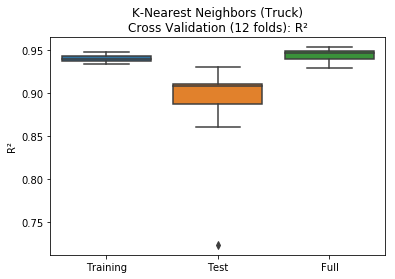

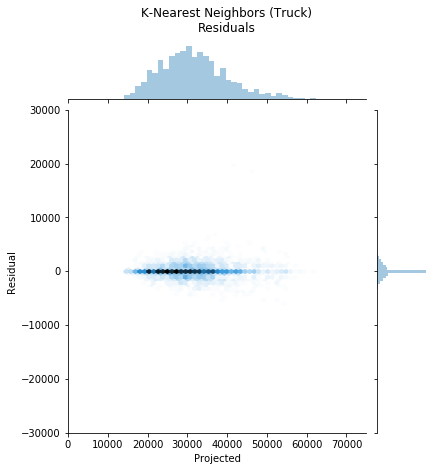

Best parameters:   {'n_neighbors': 4, 'weights': 'distance'}
R² (training set): 0.94084 (+/- 0.00886)
R² (test set):     0.88766 (+/- 0.10512)
R² (full set):     0.94433 (+/- 0.01452)


In [69]:
# Truck
tgt_Truck = data.query('Truck == True')
Y_Truck = tgt_Truck['MSRP']
X_Truck = tgt_Truck.loc[:, ~tgt_Truck.columns.isin(['MSRP'])]

X_Truck_scaled = preprocessing.scale(X_Truck)
pca_Truck = PCA(n_components=10).fit(X_Truck_scaled)
X_Truck_pca_raw = pca_Truck.transform(X_Truck_scaled)
X_Truck_pca = pd.DataFrame(data=X_Truck_pca_raw,index=X_Truck.index)
X_Truck_train, X_Truck_test, Y_Truck_train, Y_Truck_test = train_test_split(X_Truck_pca, Y_Truck, test_size=0.2)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit_Truck = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).\
    fit(X_Truck_train, Y_Truck_train)
knn_Truck_train, knn_Truck_test, knn_Truck_full = model_cv_scores(knn_fit_Truck, X_Truck_train, Y_Truck_train, \
                                                   X_Truck_test, Y_Truck_test, 12, True, 'K-Nearest Neighbors (Truck)')

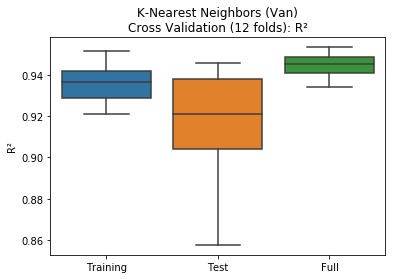

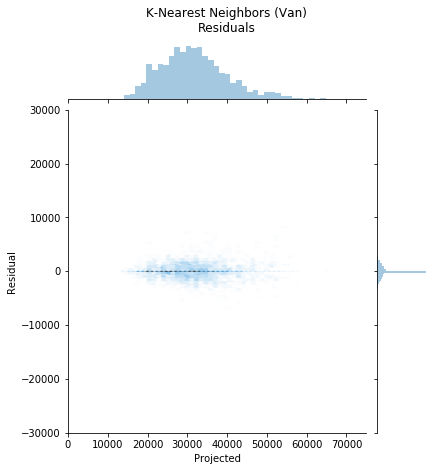

Best parameters:   {'n_neighbors': 4, 'weights': 'distance'}
R² (training set): 0.93572 (+/- 0.01797)
R² (test set):     0.91422 (+/- 0.05702)
R² (full set):     0.94454 (+/- 0.01045)


In [70]:
# Van
tgt_Van = data.query('Van == True')
Y_Van = tgt_Van['MSRP']
X_Van = tgt_Van.loc[:, ~tgt_Van.columns.isin(['MSRP'])]

X_Van_scaled = preprocessing.scale(X_Van)
pca_Van = PCA(n_components=10).fit(X_Van_scaled)
X_Van_pca_raw = pca_Van.transform(X_Van_scaled)
X_Van_pca = pd.DataFrame(data=X_Van_pca_raw,index=X_Van.index)
X_Van_train, X_Van_test, Y_Van_train, Y_Van_test = train_test_split(X_Van_pca, Y_Van, test_size=0.2)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
knn_fit_Van = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).\
    fit(X_Van_train, Y_Van_train)
knn_Van_train, knn_Van_test, knn_Van_full = model_cv_scores(knn_fit_Van, X_Van_train, Y_Van_train, \
                                                   X_Van_test, Y_Van_test, 12, True, 'K-Nearest Neighbors (Van)')

The K-Nearest Neighbors model performed well across all body styles in both the training and test sets.

|Set|All|SUV|Sedan|Coupe|Station Wagon|Truck|Van
|-|-|-|-|-|-|-|-
|Training|0.93815|0.92370|0.94362|0.94872|0.95486|0.93448|0.93896
|Test|0.87749|0.87375|0.85413|0.82574|0.85875|0.90581|0.88520
|Full|0.94744|0.93878|0.95198|0.96735|0.96303|0.94302|0.94343

In [71]:
knn_test_data = np.asarray([ knn_test, knn_SUV_test, knn_Sedan_test, knn_Coupe_test, knn_SW_test, knn_Truck_test, knn_Van_test ]).T
knn_df = pd.DataFrame(data=knn_test_data,columns=['All','SUV','Sedan','Coupe','Station_Wagon','Truck','Van'])

Although the 95% confidence intervals for the individual body styles significantly increased, the means all remained over 0.82. Coupes and station wagons have the widest interquartile ranges but also account for the smallest number of vehicles at 3.9% and 2.9% of total vehicles, respectively.

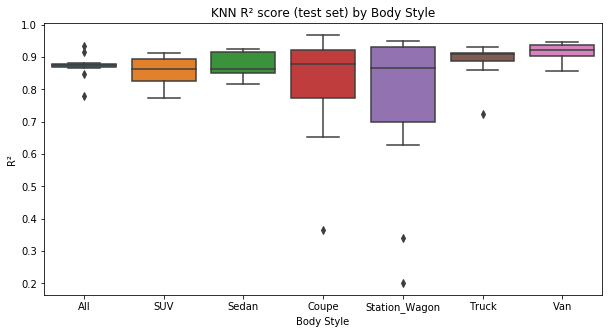

In [159]:
plt.figure(figsize=(10,5))
sns.boxplot(data=knn_df)
plt.title('KNN R\u00b2 score (test set) by Body Style')
plt.ylabel('R\u00b2')
plt.xlabel('Body Style')
plt.show()

## Save/Load Variables in Pickle (optional)

Since running this entire notebook takes a significant amount of time to run, all variables were saved to pickle format using the [Dill library](https://pypi.org/project/dill/).

In [160]:
import dill
dill.dump_session('car_msrp.db')
#dill.load_session('car_msrp.db')

## Conclusions

The K-Nearest Neighbors model and the gradient boosting regression performed best in predicting MSRP.  Both had R2 scores around 0.90.
Most of the other models had R2 values around 0.75.
Residuals were consistently normal around 0.

Body style was tested in two ways to determine whether it was significant:
- A subset of only sedans was used to run each of the individual models.
- The K-Nearest Neighbors model was applied on subsets of each individual body style.

There was no evidence that body style affected MSRP.

## Future Research

- The strength of KNN relative to some of the other models suggests that there may be some similar classes that are drawing vehicles together.  This was thought to be body style but there was no evidence of that when vehicles were broken out by body style.  An unsupervised model might be able to shed light on what might be causing clustering.
- There was no consideration given to the number of each vehicle type produced meaning a very popular vehicle model would have equal weight to a very rare one.  Weighting according to relative production would yield a more generalizable result.
- Model make could be added.  Different manufacturers may place value on different things when setting MSRP so differentiating by manufacturer could be relevant.
- Model year might provide some information on how MSRP values have evolved over time, although there may not be enough data points to draw any time-related conclusions.
- Actual car safety data could be used rather than just a list of features.  The presence of features does not guarantee their value.
- Actual car sales data rather than MSRP would provide a better picture of how consumers value cars vs. how manufacturers do.  These are affected by more factors such as location and sales date so may be less stable and more difficult to predict.